# hdpws HAPI Example Jupyter Notebook
![SPASE inside](https://spase-group.org/assets/images/spase-inside.png)
<img src="https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/HAPI.svg" alt="HAPI" width="200" height="100"/>

This [Jupyter notebook](https://jupyter.org/) demonstrates using the [hdpws](https://pypi.org/project/hdpws/) Python package to find [HAPI](http://hapi-server.org/) accessible data from the [Space Physics Archive Search and Extract](https://spase-group.org/) (SPASE) metadata documents at the [Heliophysics Data Portal](https://heliophysicsdata.gsfc.nasa.gov/) (HDP).  It then retrieves some of the data using the  [hapiclient](https://pypi.org/project/hapiclient/) library.  It assumes some familarity with the [SPASE data model](https://spase-group.org/data/index.html).  This notebook contains the following sections:
1. [Prerequisites](#Prerequisites)
2. [Setup](#Setup)
3. [Discover the Software used to access data](#Discover-the-Software-used-to-access-data)
4. [Get MeasurementTypes](#Get-MeasurementTypes)
5. [Get ObservedRegions](#Get-ObservedRegions)
6. [Get ObservatoryIDs](#Get-ObservatoryIDs)
7. [Get NumericalData](#Get-NumericalData)
8. [Get The Data](#Get-The-Data)
9. [Plot The Data](#Get-The-Data)
10. [Additional Documentation](#Additional-Documentation)

## Prerequisites
Install the prerequisite software from [Python Package Index](https://pypi.org/project/hdpws/) (PyPI) software repository.
1. pip install hdpws
2. pip install hapiclient
3. pip install hapiplot

## Setup
Execute some preliminary code that is necessary before the code that follows.

In [1]:
from datetime import datetime, timedelta
from hdpws.hdpws import HdpWs
from hdpws import NAMESPACES as NS
from hdpws.resourcetype import ResourceType as rt
from hdpws.spase import HapiAccessURL

from IPython.core.display import HTML

from hapiclient import hapi, HAPIError
from hapiplot import hapiplot

hdp = HdpWs()
# limit display of long lists
DISP_LIMIT = 5

def display_link(
    url: str,
    text: str) -> None:
    display(HTML(f'<a href="{url}" target="_blank">{text}</a>'))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Discover the Software used to access data
The following code demonstrates discovering the software we will use below to get the data we want.

In [2]:
query = {
    'CodeLanguage': 'Python',
    'Description': 'HAPI'
}
result = hdp.get_spase_software(query)
if result['HttpStatus'] == 200:
    print(f'Software search results:')
    for software in result['Result'].findall('.//Software', namespaces=NS):
        resource_id = software.findall('.//ResourceID', namespaces=NS)[0].text
        resource_name = software.findall('.//ResourceName', namespaces=NS)[0].text
        display_link(f'{hdp.endpoint}Spase?ResourceID={resource_id}', resource_name)
else:
    print(result['HttpStatus'])

Software search results:


## Get MeasurementTypes
The following code demonstrates how to get the list of available /Spase/MeasurementType values.

In [3]:
result = hdp.get_measurement_types()
print(f'HDP MeasurementTypes:')
for i, value in enumerate(result['MeasurementType']):
    print(f'{i}. {value}')


HDP MeasurementTypes:
0. ActivityIndex
1. Dopplergram
2. Dust
3. ElectricField
4. EnergeticParticles
5. Ephemeris
6. ImageIntensity
7. InstrumentStatus
8. IonComposition
9. Irradiance
10. MagneticField
11. Magnetogram
12. NeutralAtomImages
13. NeutralGas
14. Profile
15. Radiance
16. Spectrum
17. SPICE
18. ThermalPlasma
19. Waves
20. Waves.Active
21. Waves.Passive


## Get ObservedRegions
The following code demonstrates how to get the list of available /Spase/ObservedRegion values.

In [4]:
result = hdp.get_observed_regions()
observed_regions = result['ObservedRegion']
for i, value in enumerate(observed_regions):
    print(f'{i}. {value}')
    if i == DISP_LIMIT:
        print('...')
        print(f'{len(observed_regions) - 1}. {observed_regions[-1]}')
        break

0. Asteroid
1. Comet
2. Comet.1PHalley
3. Comet.26PGriggSkjellerup
4. Comet.67PChuryumovGerasimenko
5. Earth
...
124. Venus.Magnetosphere.RingCurrent


## Get ObservatoryIDs
The following code demonstrates how to get the list of available /Spase/Observatory/ResourceID values.

In [5]:
result = hdp.get_observatory_ids()
observatory_ids = result['ObservatoryID']
for i, value in enumerate(observatory_ids):
    print(f'{i}. {value}')
    if i == DISP_LIMIT:
        print('...')
        print(f'{len(observatory_ids) - 1}. {observatory_ids[-1]}')
        break

0. spase://SMWG/Observatory/AE-D
1. spase://SMWG/Observatory/Helios1
2. spase://SMWG/Observatory/DynamicsExplorer1
3. spase://SMWG/Observatory/SolarOrbiter
4. spase://SMWG/Observatory/IMP8
5. spase://SMWG/Observatory/MarsExpress
...
4043. spase://SMWG/Observatory/UNH


## Get NumericalData
The following code demonstrates how to find HAPI accessible SPASE NumericalData documents matching the specified search criteria.  It also demonstrates that a SPASE dataset may correspond to more than one HAPI dataset.  Each HAPI dataset may only have a subset of the SPASE Parameters, so it is important to get parameters of a HAPI dataset from the HAPI server itself (see [Get The Data](#Get-The-Data) section below) instead of using the SPASE ParameterKey values.

In [6]:

query = {
    'InstrumentID': 'spase://SMWG/Instrument/Wind/MFI',
    'Cadence': '=PT3S',
    'ObservedRegion': 'Heliosphere.NearEarth',
    'MeasurementType': 'MagneticField',
    'AccessRights': 'Open',
    'Style': 'HAPI'
}       
types = [rt.NUMERICAL_DATA]
time_range = ['2022-01-01', '2022-01-02']
result = hdp.get_spase_data(types, query, time_range)
if result['HttpStatus'] == 200:
    for i, spase in enumerate(result['Result'].findall('.//Spase', namespaces=NS)):
        id = spase.find('.//ResourceID', namespaces=NS)
        name = spase.find('.//Name', namespaces=NS)
        description = spase.find('.//Description',
                                 namespaces=NS)
        parameter_keys = spase.findall('.//ParameterKey',
                                       namespaces=NS)
        
        print(f'{i}. ResourceID: {id.text}')
        print('--------------------------------------------------')
        print(f'Name: {name.text}')
        print(f'Description: {description.text[:60]} ...')
        print(f'ParameterKeys (abbreviated):')
        for j, parameter_key in enumerate(parameter_keys):
            print(f'{j}.  {parameter_key.text}')
            if j == DISP_LIMIT:
                print('...')
                print(f'{len(parameter_keys) - 1}.  {parameter_keys[-1].text}')
                break
        display_link(hdp.get_spase_url(id.text), 'HTML representation of SPASE')
        hapi_access_url_element = \
            spase.find('.//AccessURL[Style="HAPI"]', namespaces=NS)
        if hapi_access_url_element is not None:
            hapi_access_url = HapiAccessURL(hapi_access_url_element)
            hapi_display_url = hapi_access_url.get_html_url()
            display_link(hapi_display_url, 'HAPI access information')
            hapi_product_keys = \
                hapi_access_url_element.findall('./ProductKey',
                                             namespaces=NS)
            print('HAPI ProductKeys:')
            for k, hapi_id in enumerate(hapi_product_keys):
                print(f'{k}.  {hapi_id.text}')
            # just use the first hapi dataset below
            hapi_product_key = hapi_product_keys[0].text
        print()

0. ResourceID: spase://NASA/NumericalData/Wind/MFI/PT03S
--------------------------------------------------
Name: Wind Spacecraft Homepage
Description: Wind MFI composite data in GSE and GSM coordinates. The file ...
ParameterKeys (abbreviated):
0.  Epoch
1.  Time_PB5
2.  NUM_PTS
3.  BF1
4.  BRMSF1
5.  BGSM
...
54.  FLAG_O


HAPI ProductKeys:
0.  WI_H0_MFI@0
1.  WI_H0_MFI@1
2.  WI_H0_MFI@2

1. ResourceID: spase://NASA/NumericalData/Wind/MFI/RTN/PT03S
--------------------------------------------------
Name: Wind Spacecraft Homepage
Description: Wind MFI composite data in RTN coordinates. The files contai ...
ParameterKeys (abbreviated):
0.  Epoch
1.  NUM_PTS
2.  BF1
3.  BRMSF1
4.  BRTN
5.  BRMSRTN
...
33.  FLAG_O


HAPI ProductKeys:
0.  WI_H3-RTN_MFI@0
1.  WI_H3-RTN_MFI@1
2.  WI_H3-RTN_MFI@2



## Get The Data
The following code demonstrates using [hapiclient](https://pypi.org/project/hapiclient/) to get the data from <b>one</b> of the HAPI datasets found above.

<b>Note:</b> Due to a TLS root Certificate-Authority (CA) certificate problem with the hapiclient on NASA EUSO (enterprise-managed) MacOS computers, the following code does not work on such computers and is therefore not well tested.  It does work on some other computers.

In [7]:
HAPI_ERROR_MSG = \
'''HAPIError: This error is likely due to a problem with the hapiclient
on certain computers (e.g., NASA EUSO [enterprise-managed] computers).
Contact the hapiclient maintainer for an update.'''

if hapi_access_url_element is not None:
    # TEMPORARY WORKAROUND for cdaweb hapi server problems
    # hapi_access_url.url = hapi_access_url.url.replace('cdaweb', 'cdaweb-dev.sci')
    try:
        print(f'HAPI dataset: {hapi_product_key}')
        meta = hapi(hapi_access_url.url, hapi_product_key)
        #print(meta)
        ds_stop = meta['stopDate']
        # change Z for python < 3.11
        stop = datetime.fromisoformat(ds_stop.replace('Z', '+00:00'))
        start = stop - timedelta(days=1)
        print(f'Example Time range: {start.isoformat()} to {stop.isoformat()}')
        parameters = meta['parameters']
        print('HAPI parameters:')
        for i, parameter in enumerate(parameters):
            print(f'{i}. {parameter["name"]}')
        select_param = parameters[1]['name']
        print(f'select_param = {select_param}')
        data, meta = hapi(hapi_access_url.url, hapi_product_key, 
                        select_param, start.isoformat(), stop.isoformat())
    except HAPIError as e:
        if 'Failed to connect' in str(e):
            print(HAPI_ERROR_MSG)
        else:
            print(e)
        data = None
        meta = None

HAPI dataset: WI_H3-RTN_MFI@0
Example Time range: 2024-10-26T23:59:30+00:00 to 2024-10-27T23:59:30+00:00
HAPI parameters:
0. Time
1. BF1
2. BRMSF1
3. BRTN
4. BRMSRTN
select_param = BF1


## Plot The Data
The following code demonstrates using [hapiplot](https://pypi.org/project/hapiplot/) to plot the data.

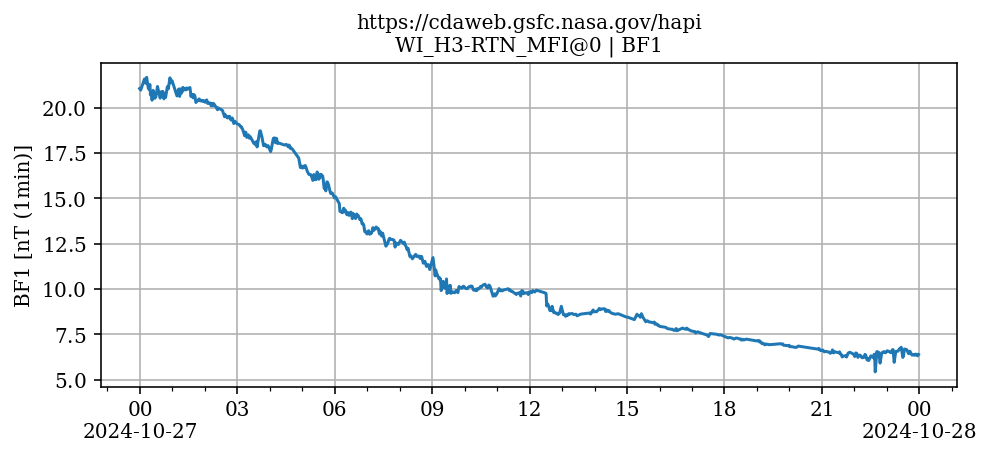

In [8]:
if data is not None:
    try:
        hapiplot(data, meta)
    except Exception as e:
        print(hapi_except_msg)
else:
    print('No data to plot.')

## Additional Documentation
View the [hdpws](https://heliophysicsdata.gsfc.nasa.gov/WebServices/py/hdpws/) API documentation for a description of additional features.